In [2]:
from tensorflow import keras
import tensorflow as tf 

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
type(X_train)

numpy.ndarray

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
y_train.shape

(60000,)

In [7]:
X_test.shape

(10000, 28, 28)

## Apply DropOut to Images
I will use the same technique that I used in Module 3; use a threshold change the data to binary. 

In [8]:
# reshape data
def reshape_X_and_y(X, y):
    return X.reshape(X.shape[0], -1), y.reshape(y.shape[0], -1)

In [9]:
X_train, y_train = reshape_X_and_y(X_train, y_train)
X_test, y_test = reshape_X_and_y(X_test, y_test)

In [10]:
# find threshold
row_means = X_train.mean(axis = 1)
threshold = row_means.max()
print(threshold)

101.3813775510204


In [11]:
import numpy as np
vectorized_threshold = np.vectorize(lambda val: 0 if val < threshold else 1)

X_train_dropout = vectorized_threshold(X_train)
X_test_dropout = vectorized_threshold(X_test)

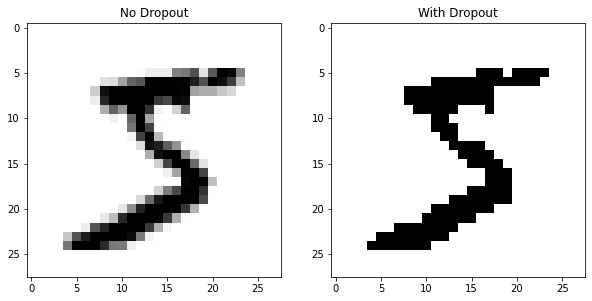

In [12]:
# visualize before and after dropout
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,20)

example = X_train[0].reshape(28,28)
example_dropout = X_train_dropout[0].reshape(28,28)
axs[0].imshow(example, cmap = mpl.cm.binary)
axs[0].set_title('No Dropout')
axs[1].imshow(example_dropout, cmap = mpl.cm.binary)
axs[1].set_title('With Dropout')

plt.show()

Find out which indices start the first 1.

In [95]:
X_tmp = np.append(X_train, X_test, axis = 0)
X_tmp = X_tmp.reshape(X_tmp.shape[0], 28, 28)

column_indices = []
for col_ind in range(X_tmp.shape[1]):
    row_checks = []
    for row_ind in range(X_tmp.shape[0]):
        row_checks.append(np.any(X_tmp[row_ind][:, col_ind]))
    column_indices.append(np.any(row_checks))

In [94]:
np.array(np.where(row_checks == 1))

array([], shape=(1, 0), dtype=int64)

In [96]:
column_indices

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

## Goal

Use Functional API to build a wide model that takes in two inputs.

In [14]:
def build_model():
    # wide input
    # input_A = keras.layers.Input(shape = )

IndentationError: expected an indented block (512567341.py, line 3)